In [31]:
import pandas as pd
import os
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from sharadar.pipeline.factors import (
    MarketCap,
    EV,
    Fundamentals
)
from sharadar.pipeline.engine import load_sharadar_bundle, symbol, symbols, make_pipeline_engine
from zipline.pipeline.filters import StaticAssets
import time
import datetime

In [32]:
spe = make_pipeline_engine()

In [33]:
bundle = load_sharadar_bundle()

In [34]:
bundle.equity_daily_bar_reader.first_trading_day

Timestamp('2000-01-01 00:00:00')

In [35]:
bundle.equity_daily_bar_reader.last_available_dt

Timestamp('2024-08-09 00:00:00')

In [36]:
pipe_start = pd.to_datetime('2024-01-05', utc=False)
pipe_end = pd.to_datetime('2024-08-01', utc=False)
macro = symbols(['TR3M', 'TR6M', 'TR1Y', 'TR2Y', 'TR3Y', 'TR5Y', 'TR7Y', 'TR10Y','TR20Y','CBOND', 'INDPRO', 'INDPROPCT', 'PMICMP', 'UNRATE', 'RATEINF'])
pipe = Pipeline(columns={
    'Close': USEquityPricing.close.latest, 
},
screen = StaticAssets(macro)
)
stocks = spe.run_pipeline(pipe, pipe_start, pipe_end)
stocks.tail(30)

[2024-08-12 21:17:05] INFO: Save root mask file: root-2024-01-05_2024-06-27_XNYS_US_0.pkl
Pipeline from 2024-01-05 to 2024-06-27
[2024-08-12 21:17:07] INFO: save term-2024-01-05_2024-06-27_screen_e109df46cd4d4382891e20a55622a9db_Close.npy to cache
[2024-08-12 21:17:07] INFO: save term-2024-01-05_2024-06-27_screen_e109df46cd4d4382891e20a55622a9db_screen_e109df46cd4d4382891e20a55622a9db.npy to cache
[2024-08-12 21:17:07] INFO: Save root mask file: root-2024-06-28_2024-08-01_XNYS_US_0.pkl
Pipeline from 2024-06-28 to 2024-08-01
[2024-08-12 21:17:07] INFO: save term-2024-06-28_2024-08-01_screen_e109df46cd4d4382891e20a55622a9db_Close.npy to cache
[2024-08-12 21:17:07] INFO: save term-2024-06-28_2024-08-01_screen_e109df46cd4d4382891e20a55622a9db_screen_e109df46cd4d4382891e20a55622a9db.npy to cache
[2024-08-12 21:17:07] INFO: Pipeline from 2024-06-28 to 2024-08-01 completed in 0:00:01.


Close
2024-07-31 Equity(10003 [TR3M])         5.140000
           Equity(10006 [TR6M])         4.920000
           Equity(10012 [TR1Y])         4.780000
           Equity(10024 [TR2Y])         4.780000
           Equity(10036 [TR3Y])         4.350000
           Equity(10060 [TR5Y])         4.160000
           Equity(10084 [TR7Y])         4.030000
           Equity(10120 [TR10Y])        4.060000
           Equity(10240 [TR20Y])        4.150000
           Equity(10400 [CBOND])        5.250000
           Equity(10410 [INDPRO])     103.994100
           Equity(10420 [INDPROPCT])    0.006445
           Equity(10430 [PMICMP])      46.800000
           Equity(10440 [UNRATE])       4.300000
           Equity(10450 [RATEINF])      2.970000
2024-08-01 Equity(10003 [TR3M])         5.150000
           Equity(10006 [TR6M])         4.910000
           Equity(10012 [TR1Y])         4.730000
           Equity(10024 [TR2Y])         4.730000
           Equity(10036 [TR3Y])         4.290000
           Equity(10060 [TR5Y])         4.100000
           Equity(10084 [TR7Y])         3.970000
           Equity(10120 [TR10Y])        4.000000
           Equity(10240 [TR20Y])        4.090000
           Equity(10400 [CBOND])        5.170000
           Equity(10410 [INDPRO])     103.994100
           Equity(10420 [INDPROPCT])    0.006445
           Equity(10430 [PMICMP])      46.800000
           Equity(10440 [UNRATE])       4.300000
           Equity(10450 [RATEINF])      2.970000

In [37]:
stocks.head(14)

Close
2024-01-05 Equity(10003 [TR3M])         5.240000
           Equity(10006 [TR6M])         5.060000
           Equity(10012 [TR1Y])         4.850000
           Equity(10024 [TR2Y])         4.850000
           Equity(10036 [TR3Y])         4.380000
           Equity(10060 [TR5Y])         4.140000
           Equity(10084 [TR7Y])         3.970000
           Equity(10120 [TR10Y])        3.990000
           Equity(10240 [TR20Y])        3.990000
           Equity(10400 [CBOND])        5.300000
           Equity(10410 [INDPRO])     101.483000
           Equity(10420 [INDPROPCT])   -0.011185
           Equity(10430 [PMICMP])      49.100000
           Equity(10440 [UNRATE])       3.700000

In [38]:
stocks.tail(14)

Close
2024-08-01 Equity(10006 [TR6M])         4.910000
           Equity(10012 [TR1Y])         4.730000
           Equity(10024 [TR2Y])         4.730000
           Equity(10036 [TR3Y])         4.290000
           Equity(10060 [TR5Y])         4.100000
           Equity(10084 [TR7Y])         3.970000
           Equity(10120 [TR10Y])        4.000000
           Equity(10240 [TR20Y])        4.090000
           Equity(10400 [CBOND])        5.170000
           Equity(10410 [INDPRO])     103.994100
           Equity(10420 [INDPROPCT])    0.006445
           Equity(10430 [PMICMP])      46.800000
           Equity(10440 [UNRATE])       4.300000
           Equity(10450 [RATEINF])      2.970000

<Axes: >

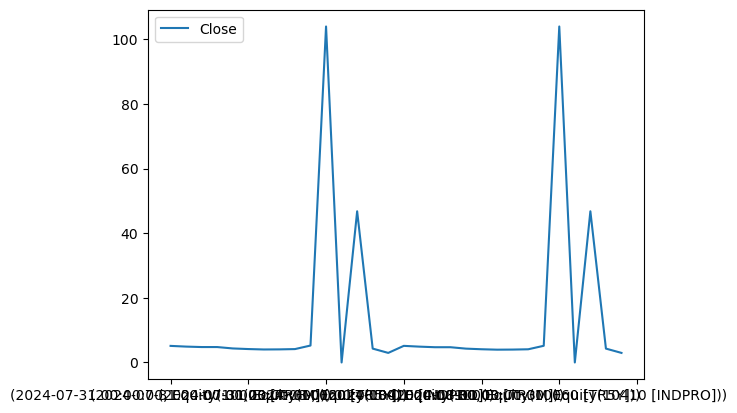

In [39]:
stocks.tail(30).plot()

In [40]:
symbol('PMICMP').to_dict()

{'sid': 10430,
 'symbol': 'PMICMP',
 'asset_name': 'Purchasing Managers Index',
 'start_date': Timestamp('1990-01-02 00:00:00'),
 'end_date': Timestamp('2024-08-09 00:00:00'),
 'first_traded': Timestamp('1990-01-02 00:00:00'),
 'auto_close_date': Timestamp('2024-08-10 00:00:00'),
 'exchange': 'MACRO',
 'exchange_full': 'MACRO',
 'tick_size': 0.01,
 'multiplier': 1.0,
 'exchange_info': ExchangeInfo('MACRO', 'MACRO', 'US')}

In [41]:
symbol('PMICMP').to_dict()

{'sid': 10430,
 'symbol': 'PMICMP',
 'asset_name': 'Purchasing Managers Index',
 'start_date': Timestamp('1990-01-02 00:00:00'),
 'end_date': Timestamp('2024-08-09 00:00:00'),
 'first_traded': Timestamp('1990-01-02 00:00:00'),
 'auto_close_date': Timestamp('2024-08-10 00:00:00'),
 'exchange': 'MACRO',
 'exchange_full': 'MACRO',
 'tick_size': 0.01,
 'multiplier': 1.0,
 'exchange_info': ExchangeInfo('MACRO', 'MACRO', 'US')}

In [42]:
symbol('^VIX')

Equity(111630 [^VIX])

In [43]:
symbol('SPY').to_dict()

{'sid': 118691,
 'symbol': 'SPY',
 'asset_name': 'SPDR S&P 500 ETF TRUST',
 'start_date': Timestamp('1993-01-29 00:00:00'),
 'end_date': Timestamp('2024-08-08 00:00:00'),
 'first_traded': Timestamp('1993-01-29 00:00:00'),
 'auto_close_date': Timestamp('2024-08-09 00:00:00'),
 'exchange': 'NYSEARCA',
 'exchange_full': 'NYSEARCA',
 'tick_size': 0.01,
 'multiplier': 1.0,
 'exchange_info': ExchangeInfo('NYSEARCA', 'NYSEARCA', 'US')}

In [44]:
symbol('SPDN').to_dict()

{'sid': 117540,
 'symbol': 'SPDN',
 'asset_name': 'DIREXION DAILY S&P 500 (R) BEAR 1X SHARES',
 'start_date': Timestamp('2016-06-08 00:00:00'),
 'end_date': Timestamp('2024-08-08 00:00:00'),
 'first_traded': Timestamp('2016-06-08 00:00:00'),
 'auto_close_date': Timestamp('2024-08-09 00:00:00'),
 'exchange': 'NYSEARCA',
 'exchange_full': 'NYSEARCA',
 'tick_size': 0.01,
 'multiplier': 1.0,
 'exchange_info': ExchangeInfo('NYSEARCA', 'NYSEARCA', 'US')}

In [45]:
ts=pd.to_datetime('2020-02-03', utc=False)
ts

Timestamp('2020-02-03 00:00:00')

In [46]:
d = {symbol('SPDN'):ts, symbol('IBM'):ts, symbol('AAPL'):ts}
d

{Equity(117540 [SPDN]): Timestamp('2020-02-03 00:00:00'),
 Equity(199623 [IBM]): Timestamp('2020-02-03 00:00:00'),
 Equity(199059 [AAPL]): Timestamp('2020-02-03 00:00:00')}

In [47]:
from pandas.tseries.offsets import MonthEnd
ts+MonthEnd(2)

Timestamp('2020-03-31 00:00:00')

In [48]:
ts+MonthEnd(0)

Timestamp('2020-02-29 00:00:00')

In [49]:
s = pd.Series()
s.loc[symbol('SPDN')]=pd.to_datetime('2020-02-14', utc=False)+MonthEnd(2)
s.loc[symbol('IBM')]=pd.to_datetime('2020-01-03', utc=False)+MonthEnd(2)
s.loc[symbol('APL')]=pd.to_datetime('2020-03-03', utc=False)+MonthEnd(2)
s

Equity(117540 [SPDN])   2020-03-31
Equity(199623 [IBM])    2020-02-29
Equity(196267 [APL])    2020-04-30
dtype: datetime64[ns]

In [50]:
class Blacklist:
    def __init__(self, expires_in_months=2):
        self.n = expires_in_months
        self.s = pd.Series()
    
    def add_symbols(self, symbols, date):
        for symbol in symbols:
            self.s.loc[symbol] = date + MonthEnd(self.n+1)
            
    def get_symbols(self, date=None):
        if date is not None:
            self.s = self.s.loc[self.s>date]
            
        print(self.s)
        return self.s.index
    
blacklist = Blacklist(2)
blacklist.add_symbols(symbols(['IBM', 'F', 'AAPL']), pd.to_datetime('2020-02-03'))
blacklist.add_symbols(symbols(['ORCL', 'MSFT']), pd.to_datetime('2020-03-10'))

assert len(blacklist.get_symbols(pd.to_datetime('2020-03-10'))) == 5, "len should be 5"
assert len(blacklist.get_symbols(pd.to_datetime('2020-04-10'))) == 5, "len should be 5"
assert len(blacklist.get_symbols(pd.to_datetime('2020-05-10'))) == 2, "len should be 2"
assert len(blacklist.get_symbols(pd.to_datetime('2020-06-10'))) == 0, "len should be 0"

Equity(199623 [IBM])    2020-04-30
Equity(199713 [F])      2020-04-30
Equity(199059 [AAPL])   2020-04-30
Equity(194684 [ORCL])   2020-05-31
Equity(198508 [MSFT])   2020-05-31
dtype: datetime64[ns]
Equity(199623 [IBM])    2020-04-30
Equity(199713 [F])      2020-04-30
Equity(199059 [AAPL])   2020-04-30
Equity(194684 [ORCL])   2020-05-31
Equity(198508 [MSFT])   2020-05-31
dtype: datetime64[ns]
Equity(194684 [ORCL])   2020-05-31
Equity(198508 [MSFT])   2020-05-31
dtype: datetime64[ns]
Series([], dtype: datetime64[ns])


In [51]:
pd.to_datetime('2020-04-30')+MonthEnd(0)

Timestamp('2020-04-30 00:00:00')

In [52]:
blacklist.get_symbols(pd.to_datetime('2020-05-10'))

Series([], dtype: datetime64[ns])


Index([], dtype='object')

In [53]:
s.loc[s>pd.to_datetime('2020-03-15', utc=False)]

Equity(117540 [SPDN])   2020-03-31
Equity(196267 [APL])    2020-04-30
dtype: datetime64[ns]

In [54]:
s.loc[s>'2020-03-15']

Equity(117540 [SPDN])   2020-03-31
Equity(196267 [APL])    2020-04-30
dtype: datetime64[ns]

In [55]:
pipe_start = pd.to_datetime('2024-01-04', utc=False)
pipe_end = pd.to_datetime('2024-07-08', utc=False)


pipe = Pipeline(columns={
    'Close': USEquityPricing.close.latest,
},
screen = StaticAssets(symbols(['IBM', 'F', 'AAPL']))
)

stocks = spe.run_pipeline(pipe, pipe_start, pipe_end)
stocks

[2024-08-12 21:17:12] INFO: Save root mask file: root-2024-01-04_2024-06-26_XNYS_US_0.pkl
Pipeline from 2024-01-04 to 2024-06-26
[2024-08-12 21:17:13] INFO: save term-2024-01-04_2024-06-26_screen_e109df46cd4d4382891e20a55622a9db_Close.npy to cache
[2024-08-12 21:17:13] INFO: save term-2024-01-04_2024-06-26_screen_e109df46cd4d4382891e20a55622a9db_screen_e109df46cd4d4382891e20a55622a9db.npy to cache
[2024-08-12 21:17:13] INFO: Save root mask file: root-2024-06-27_2024-07-08_XNYS_US_0.pkl
Pipeline from 2024-06-27 to 2024-07-08
[2024-08-12 21:17:13] INFO: save term-2024-06-27_2024-07-08_screen_e109df46cd4d4382891e20a55622a9db_Close.npy to cache
[2024-08-12 21:17:13] INFO: save term-2024-06-27_2024-07-08_screen_e109df46cd4d4382891e20a55622a9db_screen_e109df46cd4d4382891e20a55622a9db.npy to cache
[2024-08-12 21:17:13] INFO: Pipeline from 2024-06-27 to 2024-07-08 completed in 0:00:01.


Close
2024-01-04 Equity(199059 [AAPL])  184.25
           Equity(199623 [IBM])   160.10
           Equity(199713 [F])      11.71
2024-01-05 Equity(199059 [AAPL])  181.91
           Equity(199623 [IBM])   160.86
...                                  ...
2024-07-05 Equity(199623 [IBM])   175.73
           Equity(199713 [F])      12.87
2024-07-08 Equity(199059 [AAPL])  226.34
           Equity(199623 [IBM])   176.02
           Equity(199713 [F])      12.84

[381 rows x 1 columns]

In [56]:
%%time
pipe_mkt_cap = Pipeline(columns={
    'mkt_cap': MarketCap()
},
)

start_time = time.time()
stocks = spe.run_pipeline(pipe_mkt_cap, pipe_start, pipe_end)
stocks.shape

[2024-08-12 21:17:14] INFO: Load root mask file: root-2024-01-04_2024-06-26_XNYS_US_0.pkl
[2024-08-12 21:17:14] INFO: load term-2024-01-04_2024-06-26_screen_e109df46cd4d4382891e20a55622a9db_screen_e109df46cd4d4382891e20a55622a9db.npy from cache
Pipeline from 2024-01-04 to 2024-06-26
[2024-08-12 21:17:14] INFO: save term-2024-01-04_2024-06-26_screen_e109df46cd4d4382891e20a55622a9db_mkt_cap.npy to cache
[2024-08-12 21:17:14] INFO: Load root mask file: root-2024-06-27_2024-07-08_XNYS_US_0.pkl
[2024-08-12 21:17:14] INFO: load term-2024-06-27_2024-07-08_screen_e109df46cd4d4382891e20a55622a9db_screen_e109df46cd4d4382891e20a55622a9db.npy from cache
Pipeline from 2024-06-27 to 2024-07-08
[2024-08-12 21:17:14] INFO: save term-2024-06-27_2024-07-08_screen_e109df46cd4d4382891e20a55622a9db_mkt_cap.npy to cache
[2024-08-12 21:17:14] INFO: Pipeline from 2024-06-27 to 2024-07-08 completed in 0:00:00.
CPU times: user 149 ms, sys: 12.2 ms, total: 161 ms
Wall time: 163 ms


(381, 1)

In [57]:
%%time
pipe_mkt_cap_ev = Pipeline(columns={
    'mkt_cap': MarketCap(),
    'ev': EV(),
    'debt': Fundamentals(field='debtusd_arq'),
    'cash': Fundamentals(field='cashnequsd_arq')
},
screen = StaticAssets(symbols(['IBM', 'F', 'AAPL']))
)

stocks = spe.run_pipeline(pipe_mkt_cap_ev, pipe_start, pipe_end)
stocks

[2024-08-12 21:17:14] INFO: Load root mask file: root-2024-01-04_2024-06-26_XNYS_US_0.pkl
[2024-08-12 21:17:14] INFO: load term-2024-01-04_2024-06-26_screen_e109df46cd4d4382891e20a55622a9db_mkt_cap.npy from cache
[2024-08-12 21:17:14] INFO: load term-2024-01-04_2024-06-26_screen_e109df46cd4d4382891e20a55622a9db_screen_e109df46cd4d4382891e20a55622a9db.npy from cache
Pipeline from 2024-01-04 to 2024-06-26
[2024-08-12 21:17:46] INFO: save term-2024-01-04_2024-06-26_screen_e109df46cd4d4382891e20a55622a9db_ev.npy to cache
[2024-08-12 21:17:46] INFO: save term-2024-01-04_2024-06-26_screen_e109df46cd4d4382891e20a55622a9db_debt.npy to cache
[2024-08-12 21:17:46] INFO: save term-2024-01-04_2024-06-26_screen_e109df46cd4d4382891e20a55622a9db_cash.npy to cache
[2024-08-12 21:17:46] INFO: Load root mask file: root-2024-06-27_2024-07-08_XNYS_US_0.pkl
[2024-08-12 21:17:46] INFO: load term-2024-06-27_2024-07-08_screen_e109df46cd4d4382891e20a55622a9db_mkt_cap.npy from cache
[2024-08-12 21:17:46] INFO: 

mkt_cap            ev          debt  \
2024-01-04 Equity(199059 [AAPL])  2.829201e+12  2.910324e+12  1.110880e+11   
           Equity(199623 [IBM])   1.468843e+11  1.981333e+11  5.852500e+10   
           Equity(199713 [F])     4.675450e+10  1.629895e+11  1.426620e+11   
2024-01-05 Equity(199059 [AAPL])  2.817848e+12  2.898971e+12  1.110880e+11   
           Equity(199623 [IBM])   1.453320e+11  1.965810e+11  5.852500e+10   
...                                        ...           ...           ...   
2024-07-05 Equity(199623 [IBM])   1.616924e+11  2.097984e+11  6.287100e+10   
           Equity(199713 [F])     5.126160e+10  1.809556e+11  1.494150e+11   
2024-07-08 Equity(199059 [AAPL])  3.493411e+12  3.565306e+12  1.045900e+11   
           Equity(199623 [IBM])   1.631806e+11  2.112866e+11  6.287100e+10   
           Equity(199713 [F])     5.182050e+10  1.815145e+11  1.494150e+11   

                                          cash  
2024-01-04 Equity(199059 [AAPL])  2.996500e+10  
           Equity(199623 [IBM])   7.276000e+09  
           Equity(199713 [F])     2.642700e+10  
2024-01-05 Equity(199059 [AAPL])  2.996500e+10  
           Equity(199623 [IBM])   7.276000e+09  
...                                        ...  
2024-07-05 Equity(199623 [IBM])   1.476500e+10  
           Equity(199713 [F])     1.972100e+10  
2024-07-08 Equity(199059 [AAPL])  3.269500e+10  
           Equity(199623 [IBM])   1.476500e+10  
           Equity(199713 [F])     1.972100e+10  

[381 rows x 4 columns]

In [58]:
%%time
pipe = Pipeline(columns={
    'mkt_cap': MarketCap(),
    'ev': EV(),
    'debt': Fundamentals(field='debtusd_arq'),
    'cash': Fundamentals(field='cashnequsd_arq')
},
screen = StaticAssets(symbols(['IBM', 'F', 'AAPL']))
)

stocks = spe.run_pipeline(pipe, pipe_start, pipe_end)
stocks

[2024-08-12 21:17:57] INFO: Load root mask file: root-2024-01-04_2024-06-26_XNYS_US_0.pkl
[2024-08-12 21:17:57] INFO: load term-2024-01-04_2024-06-26_screen_e109df46cd4d4382891e20a55622a9db_mkt_cap.npy from cache
[2024-08-12 21:17:57] INFO: load term-2024-01-04_2024-06-26_screen_e109df46cd4d4382891e20a55622a9db_ev.npy from cache
[2024-08-12 21:17:57] INFO: load term-2024-01-04_2024-06-26_screen_e109df46cd4d4382891e20a55622a9db_debt.npy from cache
[2024-08-12 21:17:57] INFO: load term-2024-01-04_2024-06-26_screen_e109df46cd4d4382891e20a55622a9db_cash.npy from cache
[2024-08-12 21:17:57] INFO: load term-2024-01-04_2024-06-26_screen_e109df46cd4d4382891e20a55622a9db_screen_e109df46cd4d4382891e20a55622a9db.npy from cache
[2024-08-12 21:17:57] INFO: Load root mask file: root-2024-06-27_2024-07-08_XNYS_US_0.pkl
[2024-08-12 21:17:57] INFO: load term-2024-06-27_2024-07-08_screen_e109df46cd4d4382891e20a55622a9db_mkt_cap.npy from cache
[2024-08-12 21:17:57] INFO: load term-2024-06-27_2024-07-08_s

mkt_cap            ev          debt  \
2024-01-04 Equity(199059 [AAPL])  2.829201e+12  2.910324e+12  1.110880e+11   
           Equity(199623 [IBM])   1.468843e+11  1.981333e+11  5.852500e+10   
           Equity(199713 [F])     4.675450e+10  1.629895e+11  1.426620e+11   
2024-01-05 Equity(199059 [AAPL])  2.817848e+12  2.898971e+12  1.110880e+11   
           Equity(199623 [IBM])   1.453320e+11  1.965810e+11  5.852500e+10   
...                                        ...           ...           ...   
2024-07-05 Equity(199623 [IBM])   1.616924e+11  2.097984e+11  6.287100e+10   
           Equity(199713 [F])     5.126160e+10  1.809556e+11  1.494150e+11   
2024-07-08 Equity(199059 [AAPL])  3.493411e+12  3.565306e+12  1.045900e+11   
           Equity(199623 [IBM])   1.631806e+11  2.112866e+11  6.287100e+10   
           Equity(199713 [F])     5.182050e+10  1.815145e+11  1.494150e+11   

                                          cash  
2024-01-04 Equity(199059 [AAPL])  2.996500e+10  
           Equity(199623 [IBM])   7.276000e+09  
           Equity(199713 [F])     2.642700e+10  
2024-01-05 Equity(199059 [AAPL])  2.996500e+10  
           Equity(199623 [IBM])   7.276000e+09  
...                                        ...  
2024-07-05 Equity(199623 [IBM])   1.476500e+10  
           Equity(199713 [F])     1.972100e+10  
2024-07-08 Equity(199059 [AAPL])  3.269500e+10  
           Equity(199623 [IBM])   1.476500e+10  
           Equity(199713 [F])     1.972100e+10  

[381 rows x 4 columns]

In [59]:
stocks = spe.run_pipeline(pipe, pipe_start)
stocks

[2024-08-12 21:17:57] INFO: Save root mask file: root-2024-01-04_2024-01-04_XNYS_US_0.pkl
Pipeline from 2024-01-04 to 2024-01-04
[2024-08-12 21:18:03] INFO: save term-2024-01-04_2024-01-04_screen_e109df46cd4d4382891e20a55622a9db_mkt_cap.npy to cache
[2024-08-12 21:18:03] INFO: save term-2024-01-04_2024-01-04_screen_e109df46cd4d4382891e20a55622a9db_ev.npy to cache
[2024-08-12 21:18:03] INFO: save term-2024-01-04_2024-01-04_screen_e109df46cd4d4382891e20a55622a9db_debt.npy to cache
[2024-08-12 21:18:03] INFO: save term-2024-01-04_2024-01-04_screen_e109df46cd4d4382891e20a55622a9db_cash.npy to cache
[2024-08-12 21:18:03] INFO: save term-2024-01-04_2024-01-04_screen_e109df46cd4d4382891e20a55622a9db_screen_e109df46cd4d4382891e20a55622a9db.npy to cache
[2024-08-12 21:18:03] INFO: Pipeline from 2024-01-04 to 2024-01-04 completed in 0:00:05.


mkt_cap            ev          debt  \
2024-01-04 Equity(199059 [AAPL])  2.829201e+12  2.910324e+12  1.110880e+11   
           Equity(199623 [IBM])   1.468843e+11  1.981333e+11  5.852500e+10   
           Equity(199713 [F])     4.675450e+10  1.629895e+11  1.426620e+11   

                                          cash  
2024-01-04 Equity(199059 [AAPL])  2.996500e+10  
           Equity(199623 [IBM])   7.276000e+09  
           Equity(199713 [F])     2.642700e+10